In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle

In [2]:
# read the cleaned CSV
data_csv = pd.read_csv('../data/yellow/taxi_y_cleaned.csv')

In [3]:
data_csv.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'ratecodeid', 'pulocationid', 'dolocationid',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'trip_duration_seconds'],
      dtype='object')

In [4]:
print(data_csv.dtypes)

tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
ratecodeid               float64
pulocationid               int64
dolocationid               int64
payment_type               int64
fare_amount              float64
tip_amount               float64
tolls_amount             float64
total_amount             float64
trip_duration_seconds    float64
dtype: object


Since pickup, dropoff are datetime and we have duration let's drop them.
rate_code, pu_location, do_location and payment_type are all categorial so will need encoding.

In [5]:
# drop datetime columns
data_csv = data_csv.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

# one hot encode for the categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(data_csv[['ratecodeid', 'pulocationid', 'dolocationid', 'payment_type']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['ratecodeid', 'pulocationid', 'dolocationid', 'payment_type']))

# combine the original dataframe with the encoded dataframe
data_encoded = pd.concat([data_csv.drop(columns=['ratecodeid', 'pulocationid', 'dolocationid', 'payment_type']), encoded_df], axis=1)

# check the first few rows of the encoded data
data_encoded.head()


,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount,trip_duration_seconds,ratecodeid_2.0,ratecodeid_3.0,ratecodeid_4.0,...,dolocationid_259,dolocationid_260,dolocationid_261,dolocationid_262,dolocationid_263,dolocationid_264,dolocationid_265,payment_type_2,payment_type_3,payment_type_4
0,1.0,1.62,9.0,2.45,0.0,12.25,630.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.27,7.5,1.86,0.0,11.16,526.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.95,11.5,2.46,0.0,14.76,936.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,2.30,14.5,0.00,0.0,15.30,1292.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,6.0,0.69,5.0,0.00,0.0,6.80,277.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


we will use VIF to indentify if there is multicolinearity in the numerical columns as categorical are so numerous

In [6]:
# select numeric, add intercetp and constant
main_numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'tolls_amount', 'total_amount', 'trip_duration_seconds']
X_main_numeric = data_csv[main_numeric_cols].copy()
X_main_numeric['intercept'] = 1

# calculate VIF for numeric predictors
vif_data_main_numeric = pd.DataFrame()
vif_data_main_numeric["Variable"] = X_main_numeric.columns
vif_data_main_numeric["VIF"] = [variance_inflation_factor(X_main_numeric.values, i) for i in range(X_main_numeric.shape[1])]

# sort values
vif_data_main_numeric_sorted = vif_data_main_numeric.sort_values(by="VIF", ascending=False)

vif_data_main_numeric_sorted

,Variable,VIF
2,fare_amount,18.828889
4,total_amount,18.156948
6,intercept,4.840321
1,trip_distance,4.803320
3,tolls_amount,1.997968
5,trip_duration_seconds,1.020809
0,passenger_count,1.001316


total_amount and fare_amount have high VIFs which indicate multicolinearity

In [7]:
# drop 'total_amount' from the predictor
X_final = data_encoded.drop(columns=['tip_amount', 'total_amount'])
y_final = data_encoded['tip_amount']

# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=33)

# run the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# predict on test set
y_pred = model.predict(X_test)

# evaluation
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
r2 = round(r2_score(y_test, y_pred), 2)


rmse, r2



(1.71, 0.6)

RMSE of 1.71 is 'fair' in the context of tips here. 0.6 r2 seems reasonable showing the the model accounts for 60% of the variance in the tip amount

As we might expect there is high colinearity between fare_amount, tolls amount, and total_amount. We will drop total_amount since it is a derivation of these other columns in this case for the LR model.

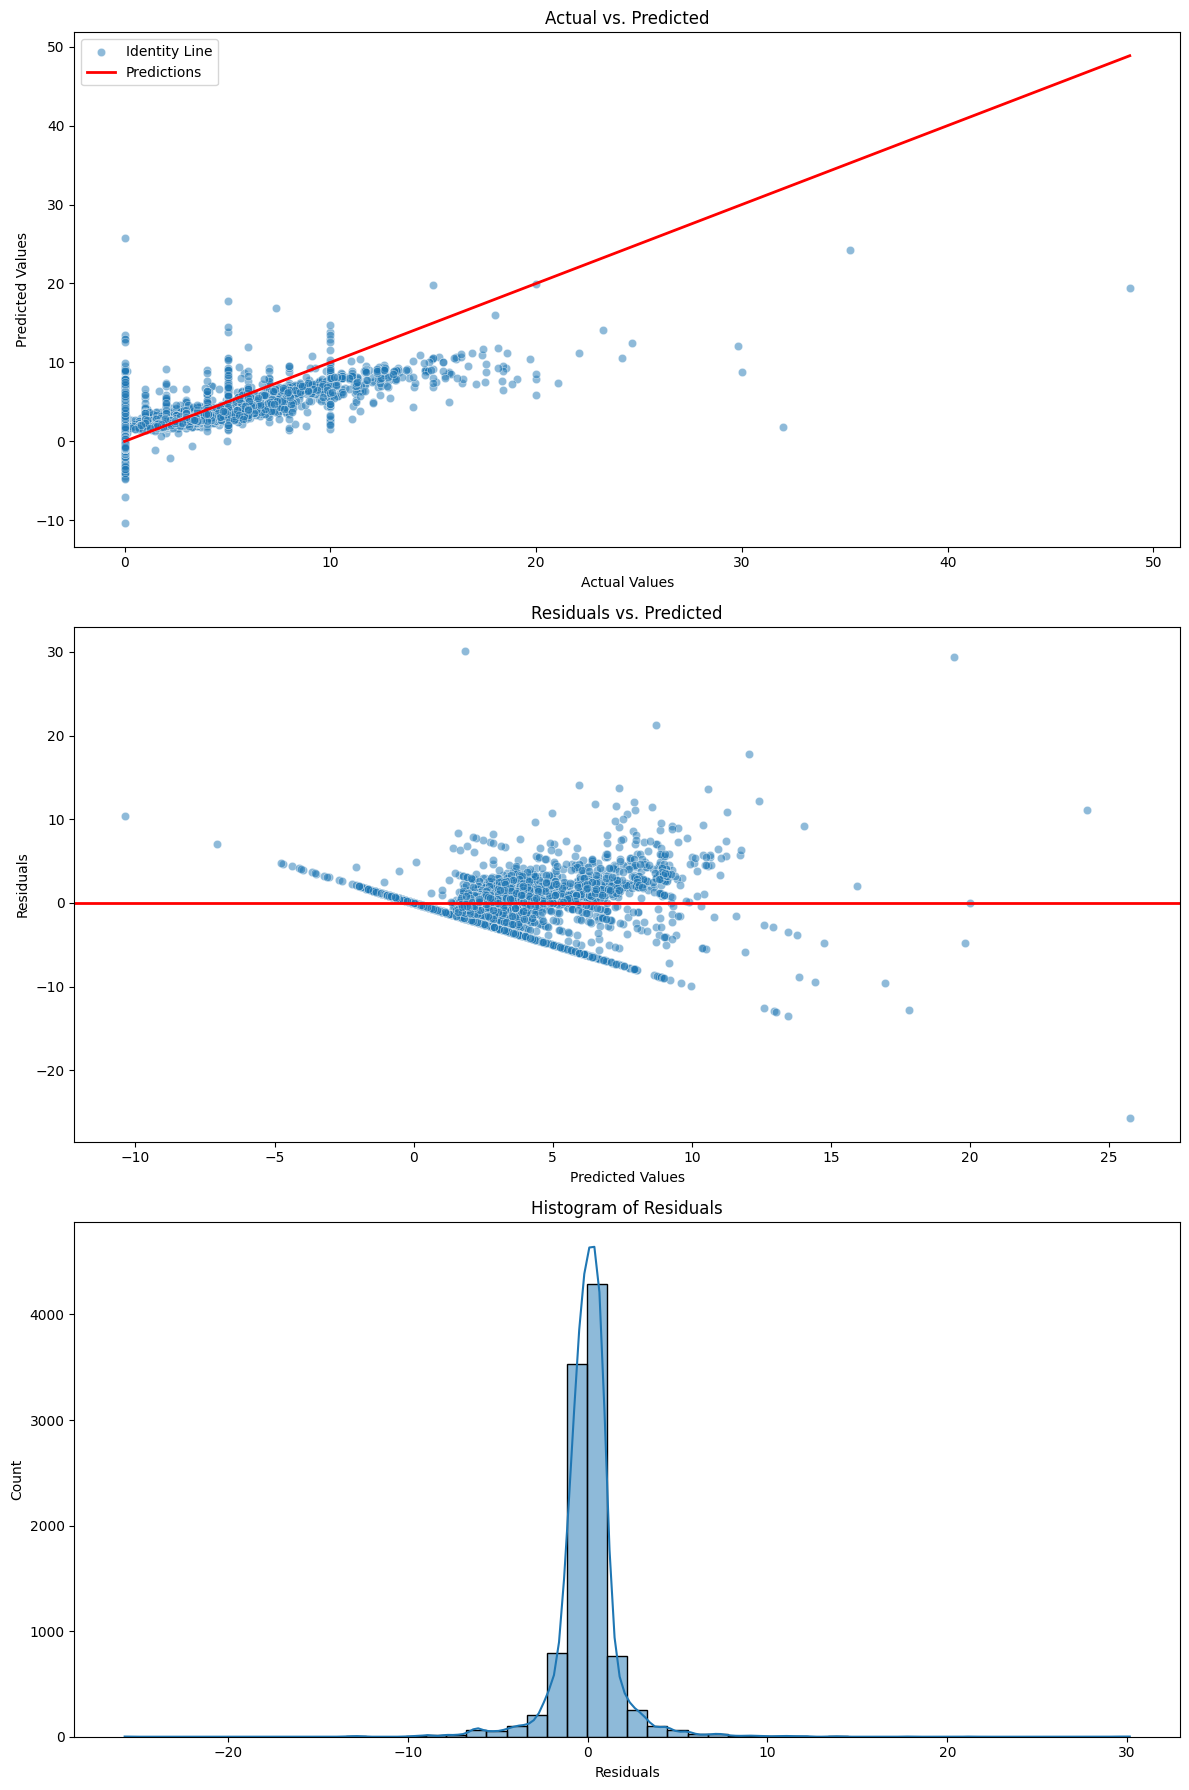

In [8]:
# define residuals
residuals = y_test - y_pred

# make plots
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# actual v predicted
sns.scatterplot(x=y_test, y=y_pred, ax=ax[0], alpha=0.5)
ax[0].set_title('Actual vs. Predicted')
ax[0].set_xlabel('Actual Values')
ax[0].set_ylabel('Predicted Values')
ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # 45-degree line
ax[0].legend(['Identity Line', 'Predictions'])

# residuals v predicted
sns.scatterplot(x=y_pred, y=residuals, ax=ax[1], alpha=0.5)
ax[1].set_title('Residuals vs. Predicted')
ax[1].set_xlabel('Predicted Values')
ax[1].set_ylabel('Residuals')
ax[1].axhline(y=0, color='red', lw=2)

# histogram of Residuals
sns.histplot(residuals, ax=ax[2], bins=50, kde=True)
ax[2].set_title('Histogram of Residuals')
ax[2].set_xlabel('Residuals')

plt.tight_layout()
plt.show()




In [ ]:
# use pickle to save model

with open('../models/linear_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)
